# Monk Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss
from utils import DataLoader
from utils import load_monk, plot_curves
from utils.model_selection_helpers import instability_coeff, tran_val_diff, count_parameters
from model.activations import sigmoid
from utils.grid_search import grid_search_monk
from IPython.display import clear_output

np.random.seed(8) #reproducibility

In [2]:
# All the configurations to test for the training
# Neural Network architectures
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [2, 4, 8]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

# Training parameters
ETA_CONFIGURATIONS = [0.1, 0.05]
LAMBDA_CONFIGURATIONS = [0, 1e-1, 1e-2, 1e-3]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
BATCH_SIZES = [16, 32, -1]

# Cross-validation parameters
K_FOLDS= 5
EPOCHS = 500
EARLY_STOPPING_PATIENCE = 50

# All possible configurations are tuples (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        for BATCH_SIZE in BATCH_SIZES:
            config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
            CONFIGURATIONS.append(config)
LEN_CONFIGURATIONS = len(CONFIGURATIONS)

print(f"Total configurations: {LEN_CONFIGURATIONS}")

Total configurations: 2592


In [3]:
# CONFIG_DICTIONARY is the id of each configuration of CONFIGURATIONS
# CONFIG_DICTIONARY_INSTABILITY_VAL is the sumatory of the relative value of when val loss raises
# CONFIG_DICTIONARY_INSTABILITY_TRAIN is the sumatory of the relative value of when train loss raises
# CONFIG_DICTIONARY_EPOCHS stores the epochs needed for each configuration to train
# CONFIG_DICTIONARY_TRAIN_LOSS_DIFF stores the sumatory of when train loss < val loss, so the model is overfitting

def print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, min_acc = 100):
    # print the top 25 configurations, sorting criterias: 1 avg accuracy (no longer valued if > than min_acc), 2 n parameters (the less the better), 3 val instability coeff (the less the better)
    TOP_25_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=lambda i: (-min(min_acc, CONFIG_DICTIONARY[i]), count_parameters(CONFIGURATIONS[i][0]), (CONFIG_DICTIONARY_INSTABILITY_VAL[i]) / K_FOLDS))[:25]
    print("Top 5 configurations:")
    for i in TOP_25_CONFIGS_INDEXES:
        ACCURACY = CONFIG_DICTIONARY[i] * 100 / K_FOLDS
        print(f'''Config index: {CONFIGURATIONS[i]}, Mean Accuracy: {ACCURACY}%,
            training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
            training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
            training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
            Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}''')

## Monk 1

In [4]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-1.train'
PATH_TEST = 'data/monk/monks-1.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_1 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_1.k_fold(k = K_FOLDS)

After one-hot encoding: X train full shape: (124, 17), X test shape: (432, 17), y train full shape: (124, 1), y test shape: (432, 1)


In [5]:
grid_s_outputs = grid_search_monk(LEN_CONFIGURATIONS, CONFIGURATIONS, k_fold, EPOCHS, EARLY_STOPPING_PATIENCE)
clear_output(wait=False)
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF = grid_s_outputs
print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF)

Top 5 configurations:
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.05, 0, 0.9, 32), Mean Accuracy: 100.0%,
            training instability coeff validation: 2.8317052671383154, 
            training instability coeff train: 51.02111578543238, 
            training loss-val loss diff: 15.122210432989963, 
            Mean Epochs: 481
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.05, 0.001, 0.9, 32), Mean Accuracy: 100.0%,
            training instability coeff validation: 3.190837896534055, 
            training instability coeff train: 19.67692446788909, 
            training loss-val loss diff: 18.190255349065616, 
            Mean Epochs: 261
Config index: ([17, 4, 1], ['relu', 'sigmoid'], 'mse', 0.05, 0.001, 0.9, 16), Mean Accuracy: 100.0%,
            training instability coeff validation: 3.9400860699350724, 
            training instability coeff train: 10.402906588135838, 
            training loss-val l

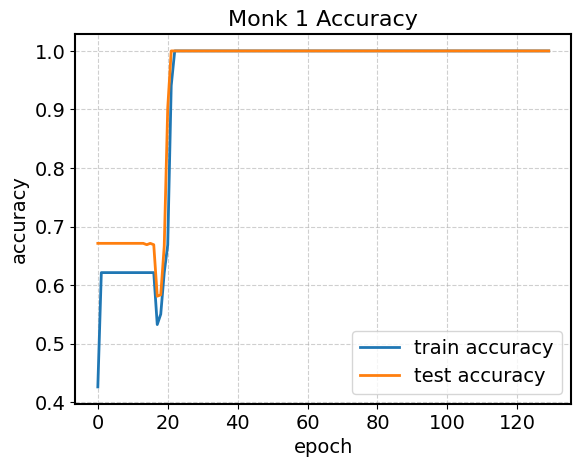

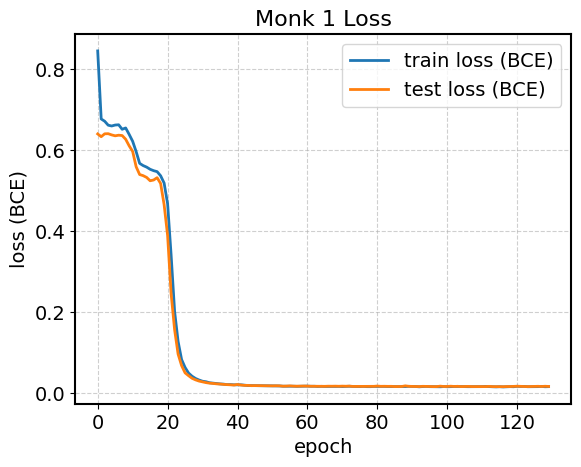

Train loss: 0.015930981209786695, Test loss: (np.float64(0.01641623854877479),)
Train Accuracy: 100.0%
Validation Accuracy: 100.0%


In [18]:
### chosen configuration
'''Config index: ([17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0.001, 0.9, 16), Mean Accuracy: 100.0%,
            training instability coeff validation: 4.013427718042067, 
            training instability coeff train: 5.148047165220225, 
            training loss-val loss diff: 4.037472546555657, 
            Mean Epochs: 130'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0.001, 0.9, 16
EPOCHS = 130

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_accuracy=True, plot_title='Monk 1 Accuracy')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 1 Loss', save_plots=True)
print(f"Train loss: {train_loss_vector[-1]}, Test loss: {test_loss_vector[-1],}")

out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")
# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Validation Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 2

In [15]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-2.train'
PATH_TEST = 'data/monk/monks-2.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_2 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_2.k_fold(k = K_FOLDS)

After one-hot encoding: X train full shape: (169, 17), X test shape: (432, 17), y train full shape: (169, 1), y test shape: (432, 1)


In [9]:
grid_s_outputs = grid_search_monk(LEN_CONFIGURATIONS, CONFIGURATIONS, k_fold, EPOCHS = 500, EARLY_STOPPING_PATIENCE = EARLY_STOPPING_PATIENCE)
clear_output(wait=False)
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF = grid_s_outputs
print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF)

Top 5 configurations:
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0, 0.9, 16), Mean Accuracy: 100.0%,
            training instability coeff validation: 0.11349963392027773, 
            training instability coeff train: 5.141263304206183, 
            training loss-val loss diff: 1.5561743558554428, 
            Mean Epochs: 500
Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.05, 0, 0.9, 16), Mean Accuracy: 100.0%,
            training instability coeff validation: 0.19331510211657754, 
            training instability coeff train: 4.362282312479167, 
            training loss-val loss diff: 3.1447720398725947, 
            Mean Epochs: 500
Config index: ([17, 4, 1], ['tanh', 'sigmoid'], 'mse', 0.05, 0, 0.9, 16), Mean Accuracy: 100.0%,
            training instability coeff validation: 0.2558181103542313, 
            training instability coeff train: 3.0464874929212242, 
            training loss-val loss di

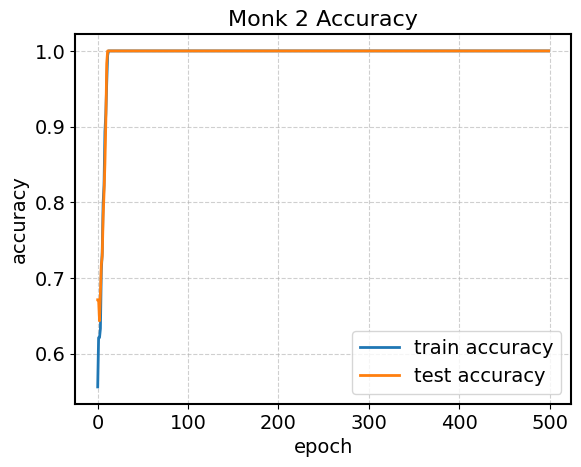

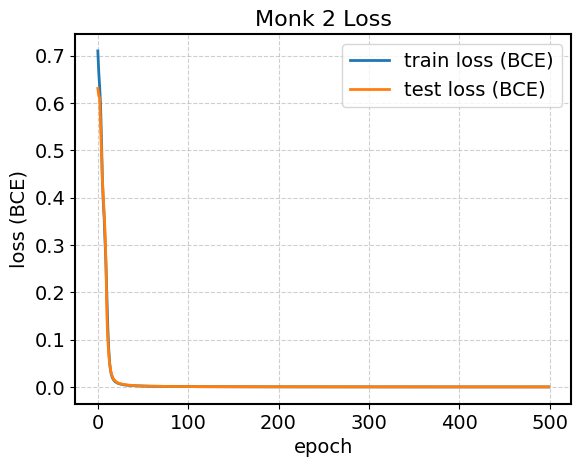

Train loss: 0.00010359333386559936, Test loss: (np.float64(0.00011246583499076856),)
Train Accuracy: 100.0%
Validation Accuracy: 100.0%


In [17]:
### chosen configuration
'''Config index: ([17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0, 0.9, 16), Mean Accuracy: 100.0%,
            training instability coeff validation: 0.11349963392027773, 
            training instability coeff train: 5.141263304206183, 
            training loss-val loss diff: 1.5561743558554428, 
            Mean Epochs: 500'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 4, 1], ['relu', 'identity'], 'binary cross entropy sigmoid', 0.1, 0, 0.9, 16
EPOCHS = 500

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_accuracy=True, plot_title='Monk 2 Accuracy')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 2 Loss', save_plots=True)

print(f"Train loss: {train_loss_vector[-1]}, Test loss: {test_loss_vector[-1],}")

out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")
# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Validation Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3

In [11]:
# Here we load the dataset and create k folds
PATH_TRAIN = 'data/monk/monks-3.train'
PATH_TEST = 'data/monk/monks-3.test'
X_train_full, y_train_full, X_test, y_test = load_monk(PATH_TRAIN, PATH_TEST)
monk_dataset_3 = DataLoader(X_train_full, y_train_full)
k_fold = monk_dataset_3.k_fold(k = K_FOLDS)

After one-hot encoding: X train full shape: (122, 17), X test shape: (432, 17), y train full shape: (122, 1), y test shape: (432, 1)


In [12]:
grid_s_outputs = grid_search_monk(LEN_CONFIGURATIONS, CONFIGURATIONS, k_fold, EPOCHS = 500, EARLY_STOPPING_PATIENCE = EARLY_STOPPING_PATIENCE)
clear_output(wait=False)
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF = grid_s_outputs
print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, min_acc=93.5)

Top 5 configurations:
Config index: ([17, 8, 1], ['tanh', 'sigmoid'], 'mse', 0.05, 0.01, 0.5, -1), Mean Accuracy: 94.3%,
            training instability coeff validation: 0.0, 
            training instability coeff train: 0.0, 
            training loss-val loss diff: 1.7395981775159448, 
            Mean Epochs: 220
Config index: ([17, 2, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.1, 0.001, 0, -1), Mean Accuracy: 93.5%,
            training instability coeff validation: 0.0, 
            training instability coeff train: 0.0, 
            training loss-val loss diff: 6.922475738515075, 
            Mean Epochs: 215
Config index: ([17, 2, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.05, 0.001, 0, -1), Mean Accuracy: 93.5%,
            training instability coeff validation: 0.0, 
            training instability coeff train: 0.0, 
            training loss-val loss diff: 2.557500483902227, 
            Mean Epochs: 265
Config index: ([17, 2, 1], ['tanh'

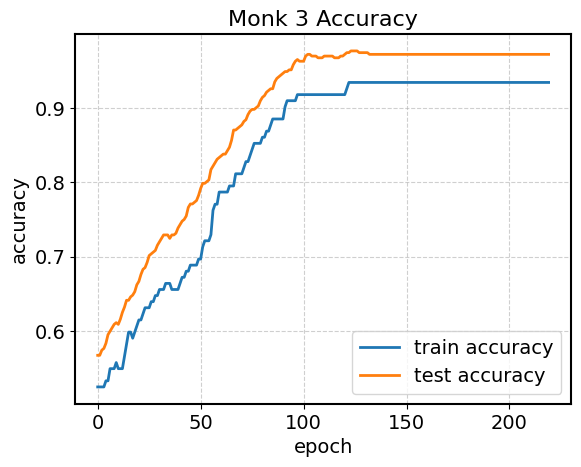

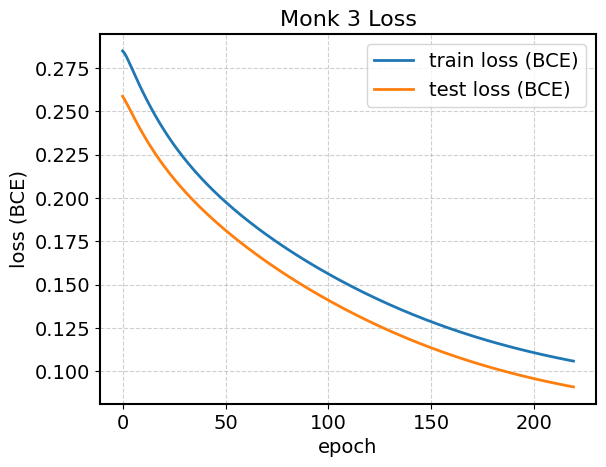

Train loss: 0.1059450030255622, Test loss: (np.float64(0.09106609102299007),)
Train Accuracy: 93.44262295081968%
Validation Accuracy: 97.22222222222221%


In [14]:
### chosen configuration
'''Config index: ([17, 8, 1], ['tanh', 'sigmoid'], 'mse', 0.05, 0.01, 0.5, -1), Mean Accuracy: 94.3%,
            training instability coeff validation: 0.0, 
            training instability coeff train: 0.0, 
            training loss-val loss diff: 1.7395981775159448, 
            Mean Epochs: 220
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 8, 1], ['tanh', 'sigmoid'], 'mse', 0.05, 0.01, 0.5, -1
EPOCHS = 220

nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_accuracy=True, plot_title='Monk 3 Accuracy')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 3 Loss', save_plots=True)

print(f"Train loss: {train_loss_vector[-1]}, Test loss: {test_loss_vector[-1],}")

out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")
# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Validation Accuracy: {np.mean(predictions == y_test) * 100}%")

## Monk 3 no reg

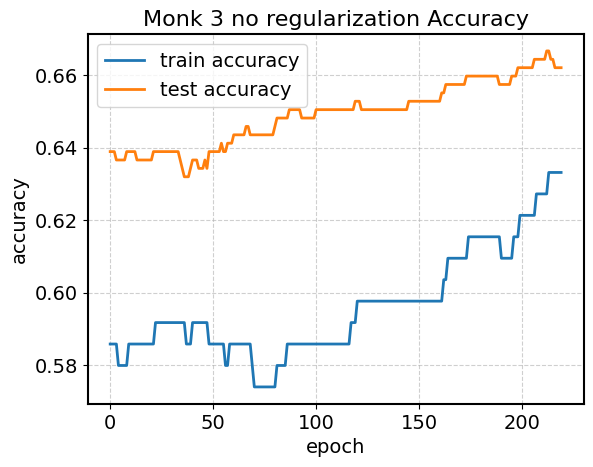

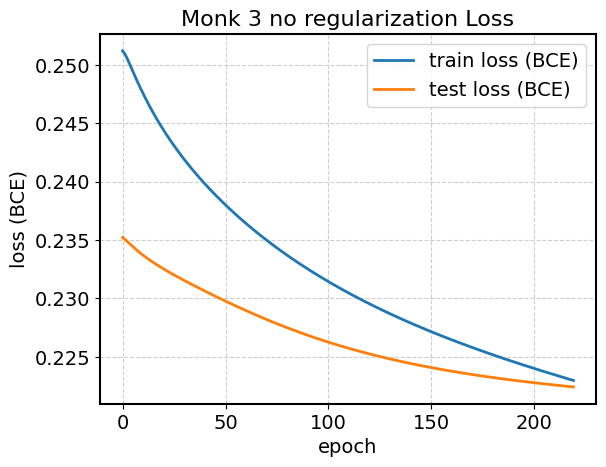

Train Accuracy: 63.31360946745562%
Test Accuracy: 66.20370370370371%


In [20]:
### chosen overfitting configuration
'''Config index: ([17, 8, 8, 1], ['leaky relu', 'leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 1e-06, 0.9, 32), Avg Epochs: 100, Mean Accuracy: 93.5%,
           training instability coeff validation: 6.942575150578747, 
           training instability coeff train: 3.1935528385008753, 
           training loss-val loss diff: 29.77263357658394, 
           Mean Epochs: 100
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set, we further increase the architecture complexity to force overfitting
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE = [17, 8, 1], ['tanh', 'sigmoid'], 'mse', 0.05, 0., 0.5, -1
EPOCHS = 220
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full,
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_accuracy=True, plot_title='Monk 3 no regularization Accuracy')

#plot curves
plot_curves(train_loss_vector, test_loss_vector, 'loss (BCE)', 'test', title = 'Monk 3 no regularization Loss', save_plots=True)

# train accuracy
out = nn.forward(X_train_full)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Train Accuracy: {np.mean(predictions == y_train_full) * 100}%")

# val accuracy, we can't early stop because we are using the test set as final evaluation, we can't pick the best nn, we have to use the last nn
out = nn.forward(X_test)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Test Accuracy: {np.mean(predictions == y_test) * 100}%")